Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "CartPole-v1"

In [2]:
import gymnasium as gym
import numpy as np
import random

In [3]:
# Cambiar render_mode a rgb_array para entrenar/testear
env = gym.make('CartPole-v1', render_mode='rgb_array')

Observation Space

In [4]:
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

Action Space

In [5]:
env.action_space

Discrete(2)

Discretización de los estados

**Nota:** es importante que chequeen el espacio de observación y el espacio de acción del entorno. Los números usados son ejemplos y pueden no ser correctos

In [6]:
cart_position = np.linspace(-0.000001, 100., 2)
cart_velocity = np.linspace(-0.000001, 100., 2)
pole_angle = np.linspace(-0.000001, 100., 2)
pole_angular_velocity = np.linspace(-0.000001, 100., 2)
cart_position

array([-1.e-06,  1.e+02])

Obtener el estado a partir de la observación

In [7]:
def get_state(obs):
    cart_pos = obs[0]
    cart_vel = obs[1]
    pole_ang = obs[2]
    pole_ang_vel = obs[3]
    cart_pos_idx = np.digitize(cart_pos, cart_position)
    cart_vel_idx = np.digitize(cart_vel, cart_velocity)
    pole_angle_idx = np.digitize(pole_ang, pole_angle)
    pole_ang_vel_idx = np.digitize(pole_ang_vel, pole_angular_velocity)
    return cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx

In [8]:
obs = env.observation_space.sample()
print(obs)
state = get_state(obs)
state

[ 0.89092636  1.4094319  -0.35153237  0.07847146]


(np.int64(1), np.int64(1), np.int64(0), np.int64(1))

Inicilización de la tabla Q

In [9]:
Q = np.zeros((len(cart_position), len(cart_velocity), len(pole_angle), len(pole_angular_velocity), env.action_space.n))
Q

array([[[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]],



       [[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]]])

Obtención de la acción a partir de la tabla Q

In [10]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

Epsilon-Greedy Policy

In [11]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = optimal_policy(state, Q)
        
    return action

Ejemplo de episodio 

In [ ]:
obs,_ = env.reset()
print(obs)
done = False
total_reward = 0
state = get_state(obs)
steps = 0
while not done:
    steps += 1
    
    # Acción del modelo
    action = epsilon_greedy_policy(state, Q, 0.5)
    print('action', action)

    obs, reward, done, _, _ = env.step(action)
    next_state = get_state(obs)
    
   # Q[state][action_idx] = ... # Completar
   
   # Actualizar estado
    state = next_state
   
    total_reward += reward

    env.render()

env.close() # Para cerrar la ventana, hay que crear el ambiente de nuevo si queremos correrlo otra vez   
print('total_reward', total_reward)
print('steps', steps)

---

## FASE 2: DISCRETIZACION DEL ESPACIO DE ESTADOS

CartPole-v1 tiene un espacio de observacion **continuo** de 4 dimensiones. Para usar Q-Learning tabular, necesitamos **discretizarlo**.

### Rangos reales de CartPole-v1:
- **Posicion del carro:** [-4.8, 4.8]
- **Velocidad del carro:** [-Inf, Inf] → practicamente [-4, 4]
- **Angulo del poste:** [-0.418, 0.418] radianes → ±24 grados
- **Velocidad angular:** [-Inf, Inf] → practicamente [-4, 4]

Vamos a implementar **dos esquemas de discretizacion** para comparar cual funciona mejor.

### ESQUEMA 1: Discretizacion Uniforme

Dividimos cada dimension en **10 bins uniformes**. Simple y balanceado.

In [12]:
import matplotlib.pyplot as plt

# ESQUEMA 1: Discretizacion Uniforme (10 bins por dimension)
bins_uniform = {
    'cart_position': np.linspace(-4.8, 4.8, 10),
    'cart_velocity': np.linspace(-4, 4, 10),
    'pole_angle': np.linspace(-0.418, 0.418, 10),
    'pole_angular_velocity': np.linspace(-4, 4, 10)
}

def get_state_uniform(obs):
    """Convierte observacion continua en estado discreto (uniforme)"""
    cart_pos_idx = np.digitize(obs[0], bins_uniform['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_uniform['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_uniform['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_uniform['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_uniform = (len(bins_uniform['cart_position']) + 1,
                       len(bins_uniform['cart_velocity']) + 1,
                       len(bins_uniform['pole_angle']) + 1,
                       len(bins_uniform['pole_angular_velocity']) + 1)

print(f"Espacio de estados (uniforme): {state_space_uniform}")
print(f"Tamano total: {np.prod(state_space_uniform):,} estados posibles")

Espacio de estados (uniforme): (11, 11, 11, 11)
Tamano total: 14,641 estados posibles


### ESQUEMA 2: Discretizacion Adaptativa

**Mayor resolucion cerca del equilibrio** (zona critica para el control). Mas bins donde mas importa.

In [14]:
# ESQUEMA 2: Discretizacion Adaptativa (mas bins cerca del equilibrio)

bins_adaptive = {
    'cart_position': np.concatenate([
        np.linspace(-4.8, -1.5, 3),    # Zona lejana izquierda
        np.linspace(-1.5, 1.5, 8),     # Zona central (CRITICA)
        np.linspace(1.5, 4.8, 3)       # Zona lejana derecha
    ]),
    'cart_velocity': np.concatenate([
        np.linspace(-4, -1, 3),
        np.linspace(-1, 1, 8),
        np.linspace(1, 4, 3)
    ]),
    'pole_angle': np.concatenate([
        np.linspace(-0.418, -0.15, 3),  # Angulo grande (dificil de recuperar)
        np.linspace(-0.15, 0.15, 12),   # Cerca del equilibrio (CRITICO)
        np.linspace(0.15, 0.418, 3)     # Angulo grande (dificil de recuperar)
    ]),
    'pole_angular_velocity': np.concatenate([
        np.linspace(-4, -1, 3),
        np.linspace(-1, 1, 8),
        np.linspace(1, 4, 3)
    ])
}

def get_state_adaptive(obs):
    """Convierte observacion continua en estado discreto (adaptativo)"""
    cart_pos_idx = np.digitize(obs[0], bins_adaptive['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_adaptive['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_adaptive['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_adaptive['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_adaptive = (len(bins_adaptive['cart_position']) + 1,
                        len(bins_adaptive['cart_velocity']) + 1,
                        len(bins_adaptive['pole_angle']) + 1,
                        len(bins_adaptive['pole_angular_velocity']) + 1)

print(f"Espacio de estados (adaptativo): {state_space_adaptive}")
print(f"Tamano total: {np.prod(state_space_adaptive):,} estados posibles")

Espacio de estados (adaptativo): (15, 15, 19, 15)
Tamano total: 64,125 estados posibles


### VERIFICACION 1: Visualizar los bins

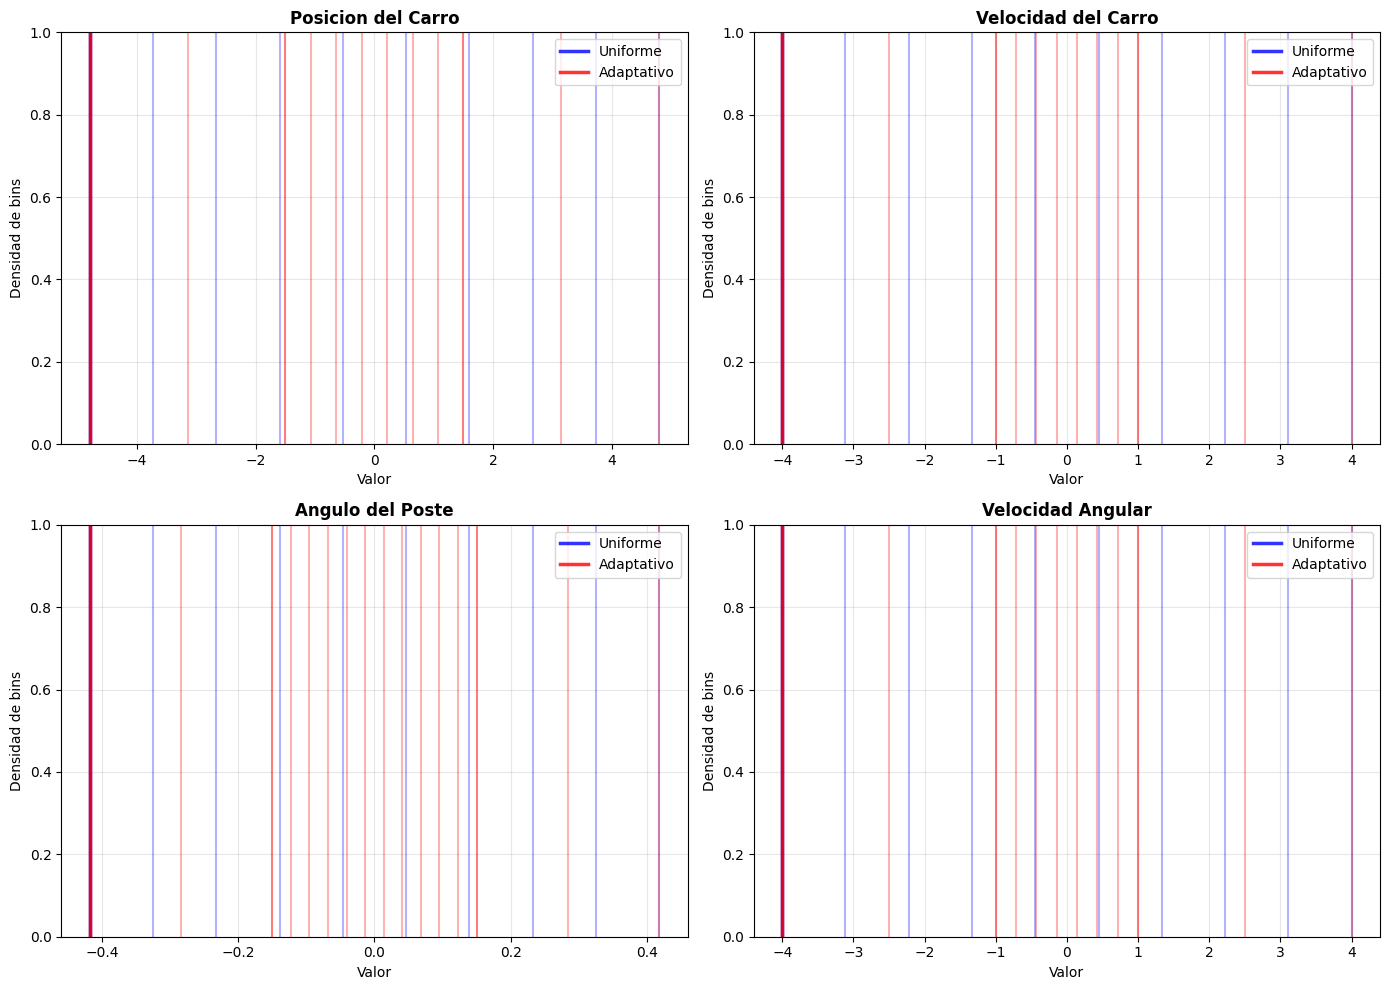


Grafico: Distribucion de bins para cada esquema
- AZUL: Uniforme (espaciado constante)
- ROJO: Adaptativo (mas denso en el centro)


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
variables = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']
titles = ['Posicion del Carro', 'Velocidad del Carro', 'Angulo del Poste', 'Velocidad Angular']

for idx, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Bins como lineas verticales
    for bin_val in bins_uniform[var]:
        ax.axvline(bin_val, color='blue', alpha=0.3, linewidth=1.5)
    for bin_val in bins_adaptive[var]:
        ax.axvline(bin_val, color='red', alpha=0.3, linewidth=1.5)
    
    # Leyenda
    ax.axvline(bins_uniform[var][0], color='blue', alpha=0.8, linewidth=2.5, label='Uniforme')
    ax.axvline(bins_adaptive[var][0], color='red', alpha=0.8, linewidth=2.5, label='Adaptativo')
    
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad de bins')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGrafico: Distribucion de bins para cada esquema")
print("- AZUL: Uniforme (espaciado constante)")
print("- ROJO: Adaptativo (mas denso en el centro)")

### VERIFICACION 2: Probar las funciones de discretizacion

In [16]:
# Test con observacion especifica
obs_test = np.array([0.5, -0.3, 0.05, 1.2])
print("Observacion de prueba:", obs_test)
print("  Estado uniforme:  ", get_state_uniform(obs_test))
print("  Estado adaptativo:", get_state_adaptive(obs_test))

# Test con muestreo aleatorio
print("\n" + "="*70)
print("Muestreando 1000 observaciones aleatorias del entorno...")
n_samples = 1000
states_uniform = []
states_adaptive = []

for _ in range(n_samples):
    obs = env.observation_space.sample()
    states_uniform.append(get_state_uniform(obs))
    states_adaptive.append(get_state_adaptive(obs))

unique_uniform = len(set(states_uniform))
unique_adaptive = len(set(states_adaptive))

print(f"\nEstados unicos visitados en el muestreo:")
print(f"  Uniforme:   {unique_uniform:,} / {np.prod(state_space_uniform):,} posibles ({unique_uniform/np.prod(state_space_uniform)*100:.1f}%)")
print(f"  Adaptativo: {unique_adaptive:,} / {np.prod(state_space_adaptive):,} posibles ({unique_adaptive/np.prod(state_space_adaptive)*100:.1f}%)")
print("\nEl esquema adaptativo tiene mas granularidad (mas estados posibles).")

Observacion de prueba: [ 0.5  -0.3   0.05  1.2 ]
  Estado uniforme:   (np.int64(5), np.int64(5), np.int64(6), np.int64(6))
  Estado adaptativo: (np.int64(8), np.int64(6), np.int64(11), np.int64(12))

Muestreando 1000 observaciones aleatorias del entorno...

Estados unicos visitados en el muestreo:
  Uniforme:   737 / 14,641 posibles (5.0%)
  Adaptativo: 908 / 64,125 posibles (1.4%)

El esquema adaptativo tiene mas granularidad (mas estados posibles).


### VERIFICACION 3: Tabla comparativa

In [17]:
import pandas as pd

comparison_data = {
    'Caracteristica': [
        'Total de estados',
        'Bins: posicion carro',
        'Bins: velocidad carro',
        'Bins: angulo poste',
        'Bins: velocidad angular',
        'Estrategia',
        'Ventaja principal'
    ],
    'Uniforme': [
        f"{np.prod(state_space_uniform):,}",
        len(bins_uniform['cart_position']),
        len(bins_uniform['cart_velocity']),
        len(bins_uniform['pole_angle']),
        len(bins_uniform['pole_angular_velocity']),
        'Espaciado constante',
        'Convergencia rapida'
    ],
    'Adaptativo': [
        f"{np.prod(state_space_adaptive):,}",
        len(bins_adaptive['cart_position']),
        len(bins_adaptive['cart_velocity']),
        len(bins_adaptive['pole_angle']),
        len(bins_adaptive['pole_angular_velocity']),
        'Denso cerca equilibrio',
        'Mejor control fino'
    ]
}

df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACION DE ESQUEMAS DE DISCRETIZACION")
print("="*80)
print(df.to_string(index=False))
print("="*80)
print("\nAmbos esquemas seran probados en la FASE 3 para ver cual funciona mejor.")


COMPARACION DE ESQUEMAS DE DISCRETIZACION
         Caracteristica            Uniforme             Adaptativo
       Total de estados              14,641                 64,125
   Bins: posicion carro                  10                     14
  Bins: velocidad carro                  10                     14
     Bins: angulo poste                  10                     18
Bins: velocidad angular                  10                     14
             Estrategia Espaciado constante Denso cerca equilibrio
      Ventaja principal Convergencia rapida     Mejor control fino

Ambos esquemas seran probados en la FASE 3 para ver cual funciona mejor.


---

## FASE 3: Q-LEARNING - ENTRENAMIENTO Y OPTIMIZACION

Implementaremos Q-Learning con:
1. **Clase QLearningAgent** - Agente completo con Q-table
2. **Funciones de entrenamiento y evaluacion** 
3. **Entrenamiento inicial** - Prueba rapida con pocos episodios
4. **Grid Search** - Busqueda de mejores hiperparametros
5. **Entrenamiento final** - Entrenamiento largo con los mejores hiperparametros

### Ecuacion de Q-Learning:
$$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

Donde:
- $\alpha$ = learning rate (tasa de aprendizaje)
- $\gamma$ = discount factor (factor de descuento)
- $r$ = reward (recompensa)
- $s$ = estado actual, $s'$ = siguiente estado
- $a$ = accion tomada

### Paso 1: Clase QLearningAgent

In [18]:
import pickle
from collections import defaultdict

class QLearningAgent:
    """
    Agente Q-Learning para CartPole con discretizacion.
    """
    def __init__(self, state_space, action_space, get_state_func,
                 alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_space = state_space
        self.action_space = action_space
        self.get_state = get_state_func
        
        # Hiperparametros
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Q-table como diccionario (valores por defecto = 0)
        self.q_table = defaultdict(lambda: 0.0)
        
        # Metricas
        self.training_rewards = []
        self.training_steps = []
        
    def get_q_value(self, state, action):
        """Obtiene valor Q para par estado-accion"""
        return self.q_table[(state, action)]
    
    def get_action(self, state, training=True):
        """Selecciona accion con epsilon-greedy policy"""
        if training and np.random.random() < self.epsilon:
            # Exploracion
            return np.random.randint(self.action_space)
        else:
            # Explotacion
            q_values = [self.get_q_value(state, a) for a in range(self.action_space)]
            return np.argmax(q_values)
    
    def update(self, state, action, reward, next_state, done):
        """Actualiza Q-table usando ecuacion de Bellman"""
        current_q = self.get_q_value(state, action)
        
        if done:
            target = reward
        else:
            max_next_q = max([self.get_q_value(next_state, a) for a in range(self.action_space)])
            target = reward + self.gamma * max_next_q
        
        # Actualizacion Q-Learning
        new_q = current_q + self.alpha * (target - current_q)
        self.q_table[(state, action)] = new_q
    
    def decay_epsilon(self):
        """Reduce epsilon despues de cada episodio"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save(self, filename):
        """Guarda el agente"""
        data = {
            'q_table': dict(self.q_table),
            'state_space': self.state_space,
            'action_space': self.action_space,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'training_rewards': self.training_rewards,
            'training_steps': self.training_steps
        }
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

print("Clase QLearningAgent definida correctamente")

Clase QLearningAgent definida correctamente


### Paso 2: Funciones de Entrenamiento y Evaluacion

In [19]:
def train_agent(agent, env, episodes=10000, print_every=1000, seed=42):
    """Entrena un agente Q-Learning"""
    np.random.seed(seed)
    random.seed(seed)
    
    for episode in range(episodes):
        obs, _ = env.reset(seed=seed+episode)
        state = agent.get_state(obs)
        
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.get_action(state, training=True)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = agent.get_state(next_obs)
            
            agent.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        agent.decay_epsilon()
        agent.training_rewards.append(total_reward)
        agent.training_steps.append(steps)
        
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(agent.training_rewards[-print_every:])
            print(f"Episodio {episode+1}/{episodes} | Avg reward (ultimos {print_every}): {avg_reward:.2f} | Epsilon: {agent.epsilon:.4f}")
    
    return agent

def evaluate_agent(agent, env, episodes=100, seed=42):
    """Evalua un agente entrenado"""
    rewards = []
    
    for episode in range(episodes):
        obs, _ = env.reset(seed=seed+episode)
        state = agent.get_state(obs)
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state, training=False)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = agent.get_state(obs)
            total_reward += reward
        
        rewards.append(total_reward)
    
    return {
        'mean': np.mean(rewards),
        'std': np.std(rewards),
        'min': np.min(rewards),
        'max': np.max(rewards),
        'success_rate': np.sum(np.array(rewards) >= 500) / episodes * 100
    }

print("Funciones de entrenamiento y evaluacion definidas")

Funciones de entrenamiento y evaluacion definidas


### Paso 3: Prueba Rapida - Baseline (1000 episodios)

Primero hacemos una prueba rapida para verificar que todo funciona.

In [20]:
# Crear agente de prueba con esquema UNIFORME
agent_test = QLearningAgent(
    state_space=state_space_uniform,
    action_space=env.action_space.n,
    get_state_func=get_state_uniform,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

print("Entrenando agente de prueba (1000 episodios)...")
print("Tiempo estimado: ~30 segundos")
print("="*70)

agent_test = train_agent(agent_test, env, episodes=1000, print_every=250, seed=42)

Entrenando agente de prueba (1000 episodios)...
Tiempo estimado: ~30 segundos
Episodio 250/1000 | Avg reward (ultimos 250): 22.72 | Epsilon: 0.2856
Episodio 250/1000 | Avg reward (ultimos 250): 22.72 | Epsilon: 0.2856
Episodio 500/1000 | Avg reward (ultimos 250): 27.78 | Epsilon: 0.0816
Episodio 500/1000 | Avg reward (ultimos 250): 27.78 | Epsilon: 0.0816
Episodio 750/1000 | Avg reward (ultimos 250): 43.17 | Epsilon: 0.0233
Episodio 750/1000 | Avg reward (ultimos 250): 43.17 | Epsilon: 0.0233
Episodio 1000/1000 | Avg reward (ultimos 250): 57.06 | Epsilon: 0.0100
Episodio 1000/1000 | Avg reward (ultimos 250): 57.06 | Epsilon: 0.0100


In [21]:
# Evaluar agente de prueba
results_test = evaluate_agent(agent_test, env, episodes=100)

print("\n" + "="*70)
print("RESULTADOS - Agente de Prueba (1000 episodios)")
print("="*70)
print(f"Reward promedio: {results_test['mean']:.2f} ± {results_test['std']:.2f}")
print(f"Reward min/max:  {results_test['min']:.0f} / {results_test['max']:.0f}")
print(f"Tasa exito:      {results_test['success_rate']:.1f}% (reward >= 500)")
print("="*70)
print("\nSi el reward promedio es > 50, todo funciona bien.")


RESULTADOS - Agente de Prueba (1000 episodios)
Reward promedio: 58.37 ± 7.68
Reward min/max:  19 / 74
Tasa exito:      0.0% (reward >= 500)

Si el reward promedio es > 50, todo funciona bien.


### Paso 4: Grid Search - Busqueda de Hiperparametros

Vamos a probar **diferentes combinaciones de hiperparametros** para encontrar la mejor configuracion.

**Grid Search:**
- **Alpha (learning rate):** [0.05, 0.1, 0.2]
- **Epsilon decay:** [0.995, 0.997, 0.999]
- **Esquemas:** Uniforme y Adaptativo

Total: **3 × 3 × 2 = 18 configuraciones**

Cada config se entrena con **5,000 episodios** (suficiente para ver tendencias).

**Tiempo estimado:** ~30-45 minutos

In [ ]:
import time
from itertools import product

# Definir grid de hiperparametros
alphas = [0.05, 0.1, 0.2]
epsilon_decays = [0.995, 0.997, 0.999]
schemes = [
    ('uniforme', state_space_uniform, get_state_uniform),
    ('adaptativo', state_space_adaptive, get_state_adaptive)
]

# Crear directorio para guardar modelos
import os
os.makedirs('models', exist_ok=True)

# Grid Search
grid_results = []
total_configs = len(alphas) * len(epsilon_decays) * len(schemes)

print("="*70)
print(f"GRID SEARCH - {total_configs} configuraciones")
print("="*70)
print("Entrenamiento: 5,000 episodios por config")
print("Tiempo estimado: ~30-45 minutos")
print("="*70)

start_time = time.time()

for idx, (alpha, eps_decay, (scheme_name, state_space, get_state_func)) in enumerate(product(alphas, epsilon_decays, schemes)):
    config_start = time.time()
    
    print(f"\n[{idx+1}/{total_configs}] alpha={alpha}, eps_decay={eps_decay}, esquema={scheme_name}")
    
    # Crear agente
    agent = QLearningAgent(
        state_space=state_space,
        action_space=env.action_space.n,
        get_state_func=get_state_func,
        alpha=alpha,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=eps_decay
    )
    
    # Entrenar
    agent = train_agent(agent, env, episodes=5000, print_every=2500, seed=42)
    
    # Evaluar
    results = evaluate_agent(agent, env, episodes=100, seed=42)
    
    # Guardar resultados
    grid_results.append({
        'alpha': alpha,
        'epsilon_decay': eps_decay,
        'scheme': scheme_name,
        'mean_reward': results['mean'],
        'std_reward': results['std'],
        'max_reward': results['max'],
        'success_rate': results['success_rate'],
        'agent': agent
    })
    
    config_time = time.time() - config_start
    print(f"   Resultado: {results['mean']:.2f} ± {results['std']:.2f} (max: {results['max']:.0f})")
    print(f"   Tiempo: {config_time:.1f}s")

total_time = time.time() - start_time
print("\n" + "="*70)
print(f"GRID SEARCH COMPLETADO en {total_time/60:.1f} minutos")
print("="*70)

### Analisis de Resultados del Grid Search

In [ ]:
# Crear DataFrame con resultados
df_grid = pd.DataFrame([{
    'Alpha': r['alpha'],
    'Eps Decay': r['epsilon_decay'],
    'Esquema': r['scheme'],
    'Reward Mean': f"{r['mean_reward']:.2f}",
    'Reward Std': f"{r['std_reward']:.2f}",
    'Max Reward': f"{r['max_reward']:.0f}",
    'Success %': f"{r['success_rate']:.1f}"
} for r in grid_results])

print("\n" + "="*90)
print("RESULTADOS COMPLETOS DEL GRID SEARCH")
print("="*90)
print(df_grid.to_string(index=False))
print("="*90)

# Encontrar mejor configuracion
best_config = max(grid_results, key=lambda x: x['mean_reward'])
print(f"\nMEJOR CONFIGURACION:")
print(f"  Alpha: {best_config['alpha']}")
print(f"  Epsilon Decay: {best_config['epsilon_decay']}")
print(f"  Esquema: {best_config['scheme']}")
print(f"  Reward Promedio: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
print(f"  Max Reward: {best_config['max_reward']:.0f}")
print(f"  Success Rate: {best_config['success_rate']:.1f}%")

### Paso 5: Entrenamiento Final con Mejores Hiperparametros

Ahora entrenamos con la mejor configuracion encontrada, pero con **muchos mas episodios** (20,000-30,000).

**Tiempo estimado:** ~15-25 minutos

In [ ]:
# Crear agente final con los mejores hiperparametros
best_scheme_name = best_config['scheme']
if best_scheme_name == 'uniforme':
    final_state_space = state_space_uniform
    final_get_state = get_state_uniform
else:
    final_state_space = state_space_adaptive
    final_get_state = get_state_adaptive

agent_final = QLearningAgent(
    state_space=final_state_space,
    action_space=env.action_space.n,
    get_state_func=final_get_state,
    alpha=best_config['alpha'],
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=best_config['epsilon_decay']
)

print("="*70)
print("ENTRENAMIENTO FINAL")
print("="*70)
print(f"Configuracion: alpha={best_config['alpha']}, eps_decay={best_config['epsilon_decay']}, esquema={best_scheme_name}")
print("Episodios: 25,000")
print("Tiempo estimado: ~20 minutos")
print("="*70)

final_start = time.time()
agent_final = train_agent(agent_final, env, episodes=25000, print_every=2500, seed=99)
final_time = time.time() - final_start

print(f"\nEntrenamiento final completado en {final_time/60:.1f} minutos")

In [ ]:
# Evaluar agente final
results_final = evaluate_agent(agent_final, env, episodes=100)

print("\n" + "="*70)
print("RESULTADOS FINALES")
print("="*70)
print(f"Reward promedio: {results_final['mean']:.2f} ± {results_final['std']:.2f}")
print(f"Reward min/max:  {results_final['min']:.0f} / {results_final['max']:.0f}")
print(f"Tasa exito:      {results_final['success_rate']:.1f}% (reward >= 500)")
print("="*70)

# Guardar modelo final
agent_final.save('models/qlearning_final.pkl')
print("\nModelo guardado en: models/qlearning_final.pkl")

# Comparar con baseline
print(f"\nMEJORA vs Baseline (1000 eps):")
print(f"  Baseline: {results_test['mean']:.2f}")
print(f"  Final:    {results_final['mean']:.2f}")
print(f"  Delta:    +{results_final['mean'] - results_test['mean']:.2f} ({(results_final['mean']/results_test['mean']-1)*100:.1f}% mejora)")

### Visualizacion de Resultados

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Curva de aprendizaje
ax = axes[0]
window = 100
rewards = agent_final.training_rewards
ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax.plot(range(len(ma)), ma, linewidth=2, color='blue')
ax.axhline(y=500, color='green', linestyle='--', linewidth=2, label='Objetivo (500)')
ax.axhline(y=results_final['mean'], color='red', linestyle='--', linewidth=2, label=f'Promedio final: {results_final["mean"]:.1f}')
ax.set_xlabel('Episodio', fontsize=12)
ax.set_ylabel(f'Reward (promedio movil {window})', fontsize=12)
ax.set_title('Curva de Aprendizaje - Agente Final', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Comparacion Grid Search (Top 5)
ax = axes[1]
top_5 = sorted(grid_results, key=lambda x: x['mean_reward'], reverse=True)[:5]
labels = [f"{r['scheme'][:3]}\nα={r['alpha']}\nε={r['epsilon_decay']}" for r in top_5]
means = [r['mean_reward'] for r in top_5]
stds = [r['std_reward'] for r in top_5]

x_pos = np.arange(len(labels))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['green' if i==0 else 'blue' for i in range(len(labels))])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel('Reward Promedio', fontsize=12)
ax.set_title('Top 5 Configuraciones del Grid Search', fontsize=14, fontweight='bold')
ax.axhline(y=500, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nGraficos generados correctamente")